In [55]:
import os
import sys
import yaml
import pypsa
import numpy as np
import pandas as pd
from pathlib import Path

sys.path.append(str(Path.cwd().parent / "data"))
from interconnection_helpers import (
    interconnection_mapper,
    interconnection_capacities,
    interconnection_countries,
)

with open(Path.cwd().parent / 'config.yaml') as f:
    config = yaml.safe_load(f)

    tech_colors = config['tech_colors']
    nice_names = config['nice_names']

In [65]:
bmus_fn = Path.cwd().parent / 'data' / 'bmus_prepared.csv'
cfd_strike_prices_fn = Path.cwd().parent / 'resources' / 'cfd_strike_prices.csv'
roc_values_fn = Path.cwd().parent / 'data' / 'roc_values.csv'
nuclear_marginal_price_fn = Path.cwd().parent / 'data' / 'nuclear_marginal_cost.csv'
battery_phs_capacities_fn = Path.cwd().parent / 'data' / 'battery_phs_capacities.csv'
wholesale_prices_fn = Path.cwd().parent / 'resources' / 'thermal_costs' / '2022-week09.csv'

pn_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'physical_notifications.csv')
europe_wholesale_prices_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'europe_day_ahead_prices.csv')
mel_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'maximum_export_limits.csv')
dah_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'day_ahead_prices.csv')

In [66]:
bmus = pd.read_csv(bmus_fn, index_col=0)

In [67]:
from datetime import datetime

datetime.strptime('2022-09-01', '%Y-%m-%d').year

2022

In [68]:
def add_wind(
        n,
        bmus,
        pn,
        mel,
        cfds,
        rocs,
        carrier=None,
    ):

    plants = (
        bmus[bmus['carrier'] == carrier]
        .index
        .intersection(pn.columns)
    )

    print(f'Adding {len(plants)} {carrier} generators...')
    print(n)
    print(bmus)
    print(pn)
    print(mel)
    print(cfds)
    print(rocs)
    
    n.add(
        "Generator",
        plants,
        bus='bus',
        carrier='onwind',
        p_nom=pn[plants].max(),
        marginal_cost=np.nan,
        efficiency=1,
        p_max_pu=pn[plants].div(pn[plants].max()).replace(np.nan, 0),
    )

    roc_generators = rocs.index.intersection(plants)
    n.generators.loc[roc_generators, 'marginal_cost'] = - rocs[roc_generators]

    cfd_generators = cfds.index.intersection(plants)
    n.generators.loc[cfd_generators, 'marginal_cost'] = 0.


def add_onshore_wind(*args):
    add_wind(*args, carrier='onwind')


def add_offshore_wind(*args):
    add_wind(*args, carrier='offwind')


def add_solar(
        n,
        bmus,
        pn,
    ):

    plants = (
        bmus[bmus['carrier'] == 'solar']
        .index
        .intersection(pn.columns)
    )

    print(f'Adding {len(plants)} solar generators...')

    n.add(
        "Generator",
        plants,
        bus='bus',
        carrier='solar',
        p_nom=pn[plants].max(),
        marginal_cost=0.,
        efficiency=1,
        p_max_pu=pn[plants].div(pn[plants].max()).replace(np.nan, 0),
    )


def add_nuclear(
        n,
        bmus,
        pn,
        nuclear_wholesale_price,
    ):

    plants = bmus[bmus['carrier'] == 'nuclear'].index

    # some nuclear-labelled BMUs always import electricity
    # these are thrown out
    plants = plants.intersection(pn.columns[pn.mean() > 0])

    print(f'Adding {len(plants)} nuclear generators...')
    n.add(
        "Generator",
        plants,
        bus='bus',
        carrier='nuclear',
        p_nom=pn[plants].max(),
        marginal_cost=nuclear_wholesale_price,
        efficiency=1,
    )

    # For nuclear units that are not constant, a 'p_max_pu' is needed
    for plant in plants:
        if len(pn[plant].unique()) > 1:
            n.generators_t['p_max_pu'].loc[:,plant] = pn[plant].div(pn[plant].max())


def add_thermal(
        n,
        bmus,
        pn,
        mel,
        wholesale_prices,
    ):

    plants = (
        bmus[bmus['carrier'].isin(['biomass', 'fossil'])]
        .index
        .intersection(pn.columns)
        .intersection(mel.columns)
    )
    print(f'Adding {len(plants)} thermal generators...')

    assert plants.isin(wholesale_prices.index).all(), 'Missing wholesale prices for some thermal plants.'    

    n.add(
        "Generator",
        plants,
        bus='bus',
        carrier=bmus.loc[plants, 'carrier'],
        p_nom=mel[plants].max(),
        marginal_cost=wholesale_prices.loc[plants],
        p_max_pu=mel[plants].div(mel[plants].max()).replace(np.nan, 0),
    )


def add_temporal_flexibility(
        n,
        bmus,
        pn,
        mel,
        battery_phs_capacities,
        carrier='battery',
        ):

    assets = bmus[bmus['carrier'] == carrier].index

    assets = assets.intersection(pn.columns).intersection(mel.columns)

    print(f'Adding {len(assets)} {carrier} storage units...')
    # times two because time step is 30 minutes and max_hours does not
    # refer to hours but time steps within the context of the network's
    # time scale
    max_hours = (
        battery_phs_capacities['energy_cap[MWh]']
        .div(battery_phs_capacities['power_cap[MW]'])
        .mul(2.)
    )

    n.add(
        "StorageUnit",
        assets,
        bus='bus',
        carrier=carrier,
        p_nom=battery_phs_capacities.loc[assets, 'power_cap[MW]'],
        max_hours=max_hours.loc[assets],
        marginal_cost=0.,
        e_cyclic=True,
        state_of_charge_initial=(
            battery_phs_capacities
            .loc[assets, 'energy_cap[MWh]']
            .div(3.) # start at 1/3 of capacity based on typical overnight charging
        ),
    )


def add_pumped_hydro(*args):
    add_temporal_flexibility(*args, carrier='PHS')


def add_batteries(*args):
    add_temporal_flexibility(*args, carrier='battery')


def add_hydropower(
        n,
        bmus,
        pn,
        roc_values, 
        carrier='hydro',
    ):

    assets = (
        bmus[bmus['carrier'] == carrier]
        .index
        .intersection(pn.columns)
    )

    print(f'Adding {len(assets)} {carrier} generators...')

    if carrier == 'cascade':
        marginal_costs = - roc_values.loc[assets]
    elif carrier == 'hydro':
        marginal_costs = 0.

    n.add(
        "StorageUnit",
        assets,
        bus="bus",
        carrier=carrier,
        p_nom=pn[assets].max(),
        marginal_cost=marginal_costs,
        e_cyclic=False,
        state_of_charge_initial=pn[assets].sum(),
        max_hours=pn[assets].sum().div(pn[assets].max()),
        p_min_pu=0.,
    )


def add_cascade(*args):
    add_hydropower(*args, carrier='cascade')


def add_dispatchable_hydro(*args):
    add_hydropower(*args, carrier='hydro')
    

def add_interconnectors(
        n,
        bmus,
        pn,
        europe_wholesale_prices,
        interconnection_mapper,
        interconnection_capacities,
        interconnection_countries,
    ):

    print(f'Adding {len(interconnection_mapper)} interconnectors...')

    for (ic, bmu_names) in interconnection_mapper.items():

        p_nom = interconnection_capacities[ic]
        country = interconnection_countries[ic]
        marginal_cost = europe_wholesale_prices.loc[:, country]

        # this setup simulates a local market for each country that
        # can either be supplied by local generators (if the local wholesale
        # price is lower than GB wholesale price) or by GB generators
        # via the interconnector (if the GB wholesale price is lower)
        if not country in n.buses.index:
            n.add(
                'Bus',
                country,
                carrier='electricity',
                )

            n.add(
                "Load",
                country,
                bus=country,
                p_set=pd.Series(0, index=pn.index),
                carrier=country,
                )

            n.add(
                "Generator",
                country,
                bus=country,
                p_nom=0.,
                marginal_cost=marginal_cost,
                carrier=country,
                )

        n.generators.loc[country, 'p_nom'] += 2 * p_nom

        n.loads.loc[country, 'p_set'] += p_nom

        n.add(
            "Link",
            ic,
            bus0='bus',
            bus1=country,
            p_nom=p_nom,
            efficiency=0.99,
            p_max_pu=1.,
            p_min_pu=-1.,
            carrier='interconnector',
            )


def build_static_supply_curve(
        n,
        bmus,
        pn,
        mel,
        wholesale_prices,
        europe_wholesale_prices,
        cfd_strike_prices,
        roc_values,
        nuclear_wholesale_price,
        battery_phs_capacities,
        interconnection_mapper,
        interconnection_capacities,
        interconnection_countries,
    ):
    """
    Builds one day of available power plants, storage units and their marginal costs.
    It is 'static' in not scaling marginal costs according to wholesale price (yet).
    """

    n.generators.loc[:, 'marginal_cost'] = np.nan
    n.storage_units.loc[:, 'marginal_cost'] = np.nan

    add_onshore_wind(n, bmus, pn, mel, cfd_strike_prices, roc_values)
    add_offshore_wind(n, bmus, pn, mel, cfd_strike_prices, roc_values)
    add_solar(n, bmus, pn)
    add_nuclear(n, bmus, pn, nuclear_wholesale_price)
    add_thermal(n, bmus, pn, mel, wholesale_prices)
    add_batteries(n, bmus, pn, mel, battery_phs_capacities)
    add_pumped_hydro(n, bmus, pn, mel, battery_phs_capacities)
    add_cascade(n, bmus, pn, roc_values)
    add_dispatchable_hydro(n, bmus, pn, roc_values)
    add_interconnectors(
        n,
        bmus,
        pn,
        europe_wholesale_prices,
        interconnection_mapper,
        interconnection_capacities,
        interconnection_countries,
        )
    
    print('\n')
    

def add_load(n, pns):

    print('Adding load...')
    n.add(
        "Load",
        "load",
        bus="bus",
        p_set=pns.clip(lower=0).sum(axis=1),
    )


def add_carriers(n, bmus, interconnection_countries):
    n.add("Carrier", bmus['carrier'].unique())
    n.add("Carrier", "load")
    n.add("Carrier", "electricity")
    n.add("Carrier", list(set(interconnection_countries.values())))


if __name__ == '__main__':

    day = '2022-02-28'

    pn = pd.read_csv(pn_fn.format(day), index_col=0, parse_dates=True)
    mel = pd.read_csv(mel_fn.format(day), index_col=0, parse_dates=True)
    europe_wholesale_prices = pd.read_csv(europe_wholesale_prices_fn.format(day), index_col=0, parse_dates=True)

    pn.index = pn.index.values
    mel.index = mel.index.values
    europe_wholesale_prices.index = europe_wholesale_prices.index.values

    wholesale_prices = (
        pd.read_csv(wholesale_prices_fn, index_col=0)
        .iloc[:,0]
    )

    cfd_strike_prices = (
        pd.read_csv(cfd_strike_prices_fn, index_col=0, parse_dates=True)
        .loc[:, :day]
        .iloc[:, -1]
        .rename('cfd_strike_price')
    )

    roc_values_fn = Path.cwd().parent / 'data' / 'roc_values.csv'
    roc_values = (
        pd.read_csv(roc_values_fn, index_col=0)
        .iloc[:,0]
        .rename('roc_value')
    )

    nuclear_wholesale_price = pd.read_csv(nuclear_marginal_price_fn, index_col=0).iloc[0,0]

    battery_phs_capacities = pd.read_csv(battery_phs_capacities_fn, index_col=0)


    n = pypsa.Network()

    add_carriers(n, bmus, interconnection_countries)

    n.add("Bus", "bus", carrier="electricity")
    n.set_snapshots(pn.index)

    build_static_supply_curve(
        n,
        bmus,
        pn,
        mel,
        wholesale_prices,
        europe_wholesale_prices,
        cfd_strike_prices,
        roc_values,
        nuclear_wholesale_price,
        battery_phs_capacities,
        interconnection_mapper,
        interconnection_capacities,
        interconnection_countries,
        )
    
    add_load(n, pn)


C:\Users\lukas\AppData\Local\Temp\ipykernel_39888\1282819270.py:365: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(cfd_strike_prices_fn, index_col=0, parse_dates=True)


Adding 97 onwind generators...
Adding 68 offwind generators...
Adding 0 solar generators...
Adding 10 nuclear generators...
Adding 106 thermal generators...
Adding 27 battery storage units...
Adding 17 PHS storage units...
Adding 7 cascade generators...
Adding 18 hydro generators...
Adding 9 interconnectors...


Adding load...


In [69]:
n.optimize()

c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 98.53it/s]
INFO:linopy.io: Writing time: 0.43s
INFO:linopy.solvers:Log file at C:\Users\lukas\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 24144 primals, 52223 duals
Objective: 5.35e+07
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, Storage

('ok', 'optimal')

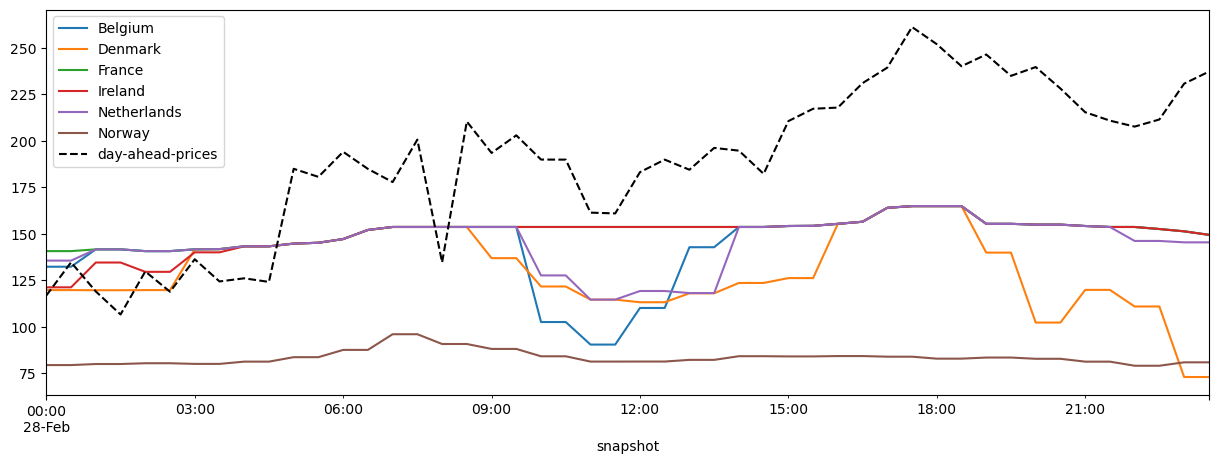

In [70]:
import matplotlib.pyplot as plt

dah = pd.read_csv(dah_fn.format(day), index_col=0, parse_dates=True)

fig, ax = plt.subplots(figsize=(15, 5))
n.buses_t.marginal_price.drop(columns='bus').plot(ax=ax)
dah.plot(ax=ax, color='black', linestyle='--')

plt.show()

In [71]:
n.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
interconnector,0.0,,,inf,0.0
battery,0.0,,,inf,0.0
demand_flex,0.0,,,inf,0.0
fossil,0.0,,,inf,0.0
onwind,0.0,,,inf,0.0
hydro,0.0,,,inf,0.0
cascade,0.0,,,inf,0.0
biomass,0.0,,,inf,0.0
offwind,0.0,,,inf,0.0


In [72]:
def plot_merit_order(n, period=36):

    print(list(n.storage_units_t))



plot_merit_order(n)

['p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'spill_cost', 'marginal_cost', 'marginal_cost_quadratic', 'marginal_cost_storage', 'state_of_charge_set', 'efficiency_store', 'efficiency_dispatch', 'standing_loss', 'inflow', 'p', 'p_dispatch', 'p_store', 'q', 'state_of_charge', 'spill', 'mu_upper', 'mu_lower', 'mu_state_of_charge_set', 'mu_energy_balance']


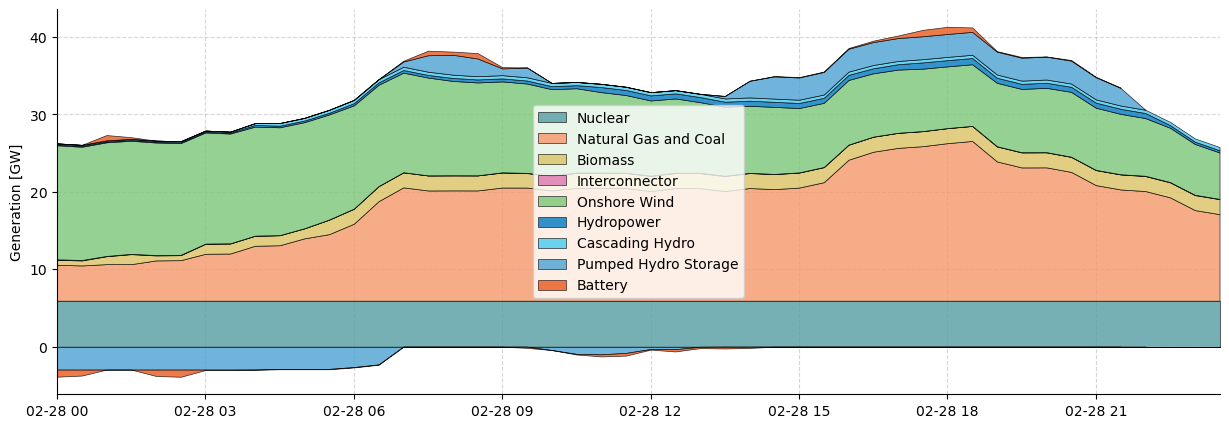

In [73]:
from collections import OrderedDict

idx = pd.IndexSlice

# totals = n.statistics.supply(
totals = n.statistics.energy_balance(
    comps=['Generator', 'StorageUnit', 'Link'],
    aggregate_time=False,
)

totals = (
    totals
    .loc[totals.index.get_level_values(1).isin(list(tech_colors))]
    .droplevel([0,2])
    .mul(1e-3)
)

totals = totals.loc[pd.Index(list(tech_colors)).intersection(totals.index)]

fig, ax = plt.subplots(figsize=(15, 5))

area_kwargs = dict(
    alpha=0.8,
    linewidth=0.5,
    edgecolor='black',
)

ax.stackplot(
    totals.columns,
    totals.clip(lower=0),
    labels=[nice_names[tech] for tech in totals.index],
    colors=[tech_colors[tech] for tech in totals.index],
    **area_kwargs
    )

ax.stackplot(
    totals.columns,
    totals.clip(upper=0),
    labels=[nice_names[tech] for tech in totals.index],
    colors=[tech_colors[tech] for tech in totals.index],
    **area_kwargs
    )

def get_unique_handles_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = OrderedDict()
    for handle, label in zip(handles, labels):
        if label not in unique:
            unique[label] = handle
    return list(unique.values()), list(unique.keys())

# Clean up the legend
handles, labels = get_unique_handles_labels(ax)
ax.legend(handles, labels)
ax.set_xlim(totals.columns.min(), totals.columns.max())

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Generation [GW]')

plt.show()

Index(['BritNed', 'IFA1', 'IFA2', 'EastWest', 'Moyle', 'Nemo', 'Viking',
       'ElecLink', 'NSL'],
      dtype='object', name='Link')


<Axes: xlabel='snapshot'>

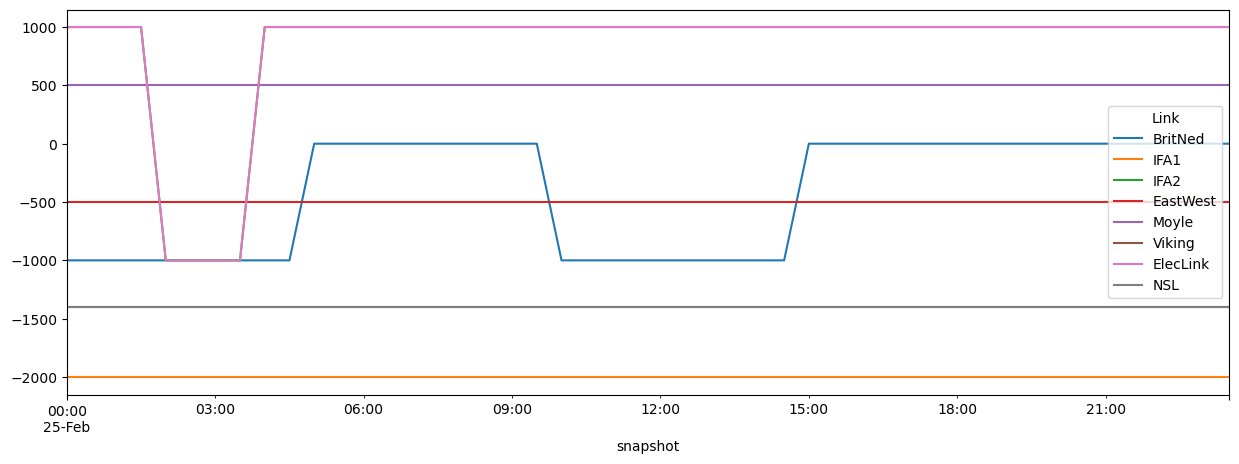

In [53]:
totals.loc['interconnector']
ints = n.links.loc[n.links.carrier == 'interconnector'].index

print(ints)

fig, ax = plt.subplots(figsize=(15, 5))
n.links_t.p0[ints.drop("Nemo")].plot(ax=ax)

<Axes: xlabel='snapshot'>

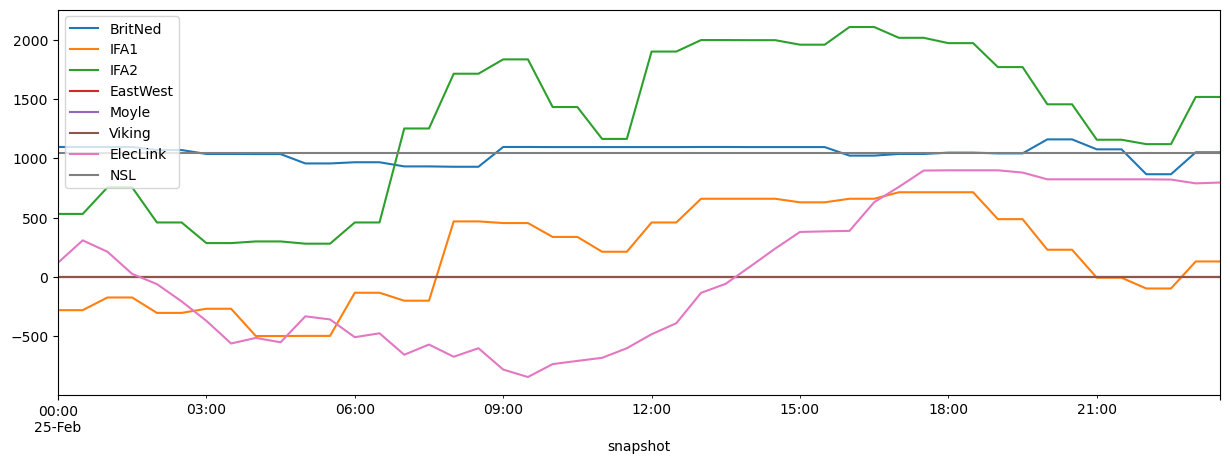

In [50]:
real_int_flow = pd.DataFrame(index=n.links_t.p0[ints].index)

for name, bmu_names in interconnection_mapper.items():

    if name == 'Nemo':
        continue
    real_int_flow[name] = pn[pn.columns[pn.columns.str.contains('|'.join(bmu_names))]].sum(axis=1)

fig, ax = plt.subplots(figsize=(15, 5))
real_int_flow.plot(ax=ax)

In [29]:

def plot_power_flow(n, colours, nice_names):

    summed_generation = []
    carrz = []

    for carrier in n.generators.carrier.unique():
        carrz.append(carrier)
        summed_generation.append(
            n.generators_t.p[
                n.generators.loc[n.generators.carrier == carrier].index]
                .sum(axis=1))

    for carrier in n.storage_units.carrier.unique():
        carrz.append(carrier)
        summed_generation.append(
            n.storage_units_t.p[
                n.storage_units.loc[n.storage_units.carrier == carrier].index]
                .sum(axis=1))


plot_power_flow(n, colors, nice_names)

NameError: name 'colors' is not defined

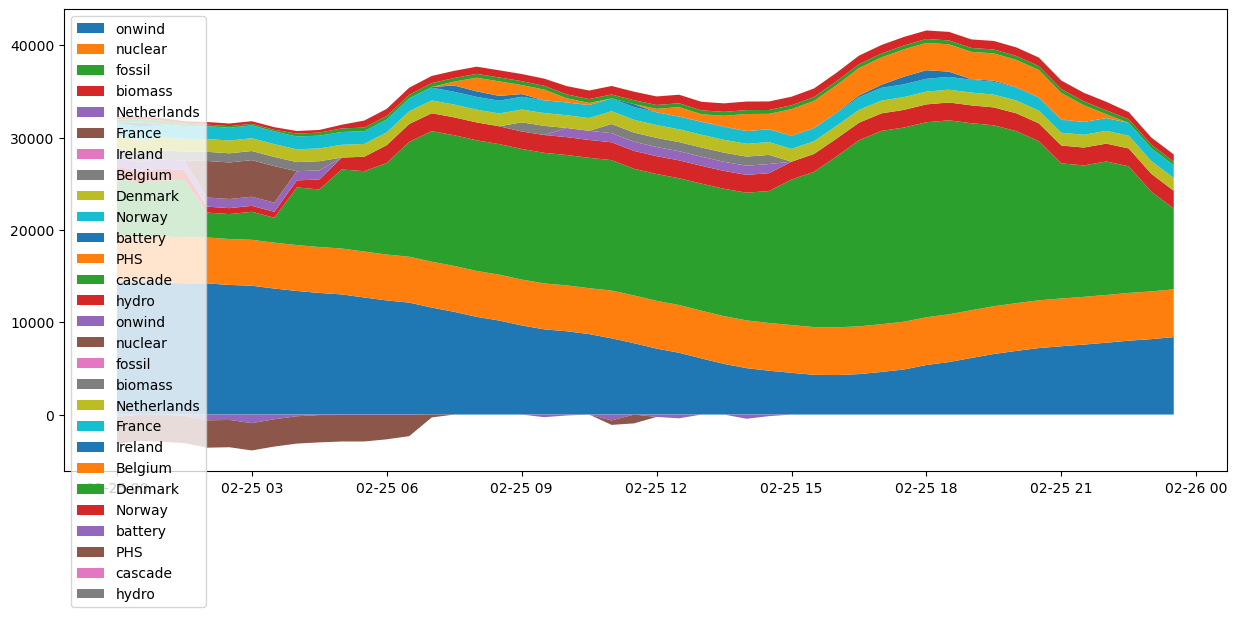

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

pos = pd.concat(summed_generation, axis=1).clip(lower=0)
neg = pd.concat(summed_generation, axis=1).clip(upper=0)

ax.stackplot(
    summed_generation[0].index,
    *[pos[c] for c in pos.columns],
    labels=carrz,
)
ax.stackplot(
    summed_generation[0].index,
    *[neg[c] for c in pos.columns],
    labels=carrz,
)
ax.legend(loc='upper left')



In [ ]:
def add_demand(n, bmus, pn, mel):

    loads = bmus[bmus['carrier'] == 'demand'].index.intersection(pn.columns)

    print(f'Adding {len(loads)} demand loads...')

    n.add(
        "Load",
        loads,
        bus='bus',
        p_set=pn[loads],
    )

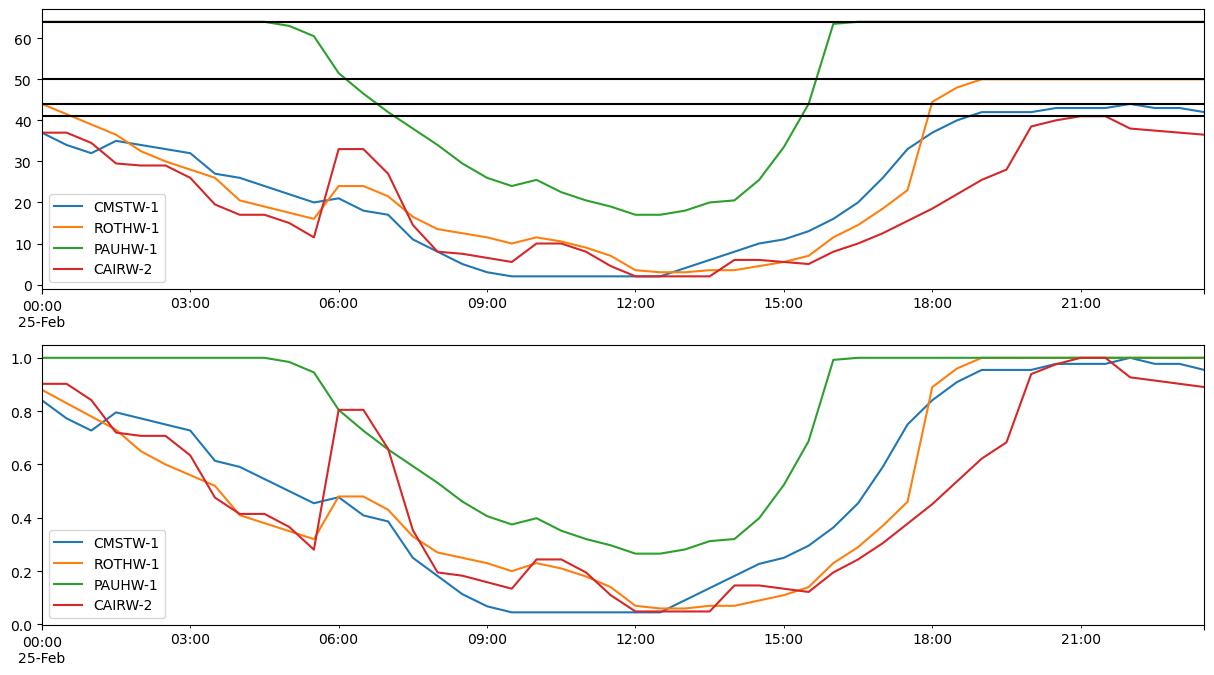

In [32]:
import matplotlib.pyplot as plt

onshore = bmus[bmus['carrier'] == 'onwind'].index.intersection(pn.columns).intersection(mel.columns)[:4]

fig, axs = plt.subplots(2, 1, figsize=(15, 8))

pn.loc[:, onshore].plot(ax=axs[0])
for i in onshore:
    axs[0].axhline(pn[i].max(), color='black')

normalised_pn = pn[onshore].div(pn[onshore].max())
normalised_pn.loc[:, onshore].plot(ax=axs[1])

plt.show()

In [33]:
normalised_pn

,CMSTW-1,ROTHW-1,PAUHW-1,CAIRW-2
2022-02-25 00:00:00,0.840909,0.88,1.000000,0.902439
2022-02-25 00:30:00,0.772727,0.83,1.000000,0.902439
2022-02-25 01:00:00,0.727273,0.78,1.000000,0.841463
2022-02-25 01:30:00,0.795455,0.73,1.000000,0.719512
2022-02-25 02:00:00,0.772727,0.65,1.000000,0.707317
2022-02-25 02:30:00,0.750000,0.60,1.000000,0.707317
2022-02-25 03:00:00,0.727273,0.56,1.000000,0.634146
2022-02-25 03:30:00,0.613636,0.52,1.000000,0.475610
2022-02-25 04:00:00,0.590909,0.41,1.000000,0.414634
2022-02-25 04:30:00,0.545455,0.38,1.000000,0.414634


<Axes: >

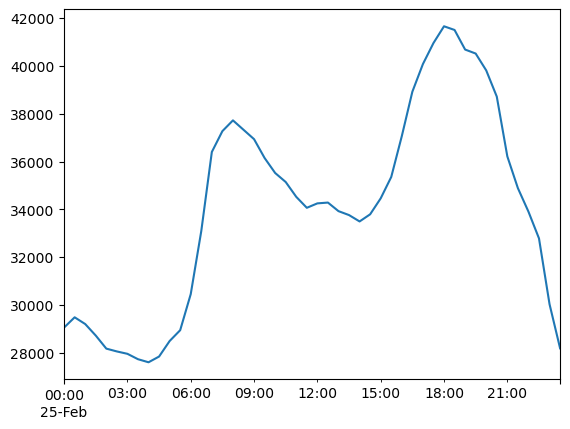

In [19]:
pn.clip(lower=0).sum(axis=1).plot()